# Notebook to walk through ViT paper code

在计算机视觉领域中，多数算法都是保持CNN整体结构不变，在CNN中增加attention模块或者使用attention模块替换CNN中的某些部分。有研究者提出，没有必要总是依赖于CNN。因此，作者提出ViT算法，仅仅使用Transformer结构也能够在图像分类任务中表现很好。

受到NLP领域中Transformer成功应用的启发，ViT算法中尝试将标准的Transformer结构直接应用于图像，并对整个图像分类流程进行最少的修改。具体来讲，ViT算法中，会将整幅图像拆分成小图像块，然后把这些小图像块的线性嵌入序列作为Transformer的输入送入网络，然后使用监督学习的方式进行图像分类的训练。

该算法在中等规模（例如ImageNet）以及大规模（例如ImageNet-21K、JFT-300M）数据集上进行了实验验证，发现：

Transformer相较于CNN结构，缺少一定的平移不变性和局部感知性，因此在数据量不充分时，很难达到同等的效果。具体表现为使用中等规模的ImageNet训练的Transformer会比ResNet在精度上低几个百分点。

当有大量的训练样本时，结果则会发生改变。使用大规模数据集进行预训练后，再使用迁移学习的方式应用到其他数据集上，可以达到或超越当前的SOTA水平。



# Prepare the Cifar100 Dataset

Files already downloaded and verified
Files already downloaded and verified


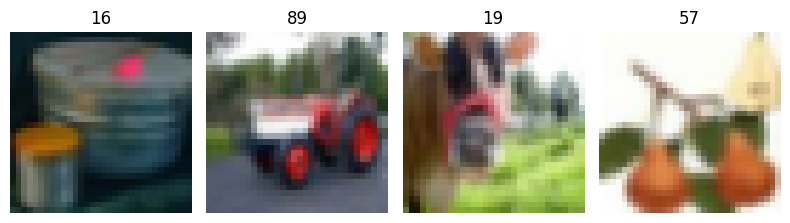

In [6]:
import random

from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

train_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(
            size=(32, 32),
            scale=(0.8, 1.0),
            ratio=(0.75, 1.3333333333333333),
            interpolation=transforms.InterpolationMode.BILINEAR
        ),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)


train_ratio = 0.8
val_ratio = 1 - train_ratio
num_train_samples = int(len(train_dataset) * train_ratio)
num_val_samples = len(train_dataset) - num_train_samples
train_dataset, val_dataset = random_split(train_dataset, [num_train_samples, num_val_samples])

test_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

samples = [train_dataset[i] for i in \
           random.sample(range(len(train_dataset)), 4)]

import matplotlib.pyplot as plt
# 创建一个2x2的图像展示
fig, axes = plt.subplots(1, 4, figsize=(8, 8))

for ax, (data, gdth) in zip(axes.flatten(), samples):
    img = data.numpy().transpose((1, 2, 0))  # 将图像维度从 (C, H, W) 转为 (H, W, C)
    img = (img * 0.5) + 0.5  # 反归一化

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{gdth}")

plt.tight_layout()
plt.show()

# Prepare the ViT model

# 理解注意力机制

注意力机制的本质是对已有参考（先验分布）的加权求和。使用一个评分函数计算查询与键之间的相似度作为值的参考权重，所有键值对的权重系数再经过 softmax 计算得到最终注意力权重分配，所有值与其对应的权重进行加权求和得到注意力输出。

用数学语言描述，假设有一个查询 $q\in\mathbf{R}^n$，和 $m$ 个键值对 $(k_1, v_1),\dots,(k_m, v_m)$ ，其中键值对的特征维度是 $k\in\mathbf{R^k},v\in\mathbf{R^v}$ 则注意力汇聚函数 $f$ 的数学表达式是：
$$
f(q,(k_1,v_1),\dots,(k_m,v_m)) = \sum_{i=1}^{m} \alpha(q,k_i)v_i
$$

其中 $\alpha$ 评分函数需要处理查询和键特征维度不同的问题。因为两个相同维度的向量进行点积，实际上得到的是两个向量的共线程度，或者说相似程度，也即 $A \cdot B = |A|\times|B|\times cos\theta$ ，当两个向量都是单位长度 $1$ 的时候，实际的计算结果只剩下一个相似性度量 $cos\theta$ 。虽然在注意力机制评分函数的计算中，我们不能保证向量是单位化的，但是由于自注意力机制是用同一个向量 $A$ 去对所有其他向量 $B$ 进行相似度计算，所以所有相似度结果 $cos\theta_i$ 其实和单位化后的相似度结果，它们的相对顺序是保持一致的，由于我们对某个键值对重要性的评估实际上只看它相对于其他键值对的相似性评分的相对大小，而不是绝对值，所以不单位化参与计算的查询和键其实没多大影响，主要解决的是查询和键的维度不一致的问题，因此才引入了线性变换矩阵乘法 $W_q$ 和 $W_k$ 把查询和键的特征维度映射到能够一起做点积的相同维度数量。

一个句子是 $n$ 个词嵌入向量，每个词嵌入向量维度 $m$ ，那么查询就是 $n$ 行 $m$ 列的矩阵 $Q\in\mathbf{R}^{n\times m}$，其中每行是一个查询；同理对于键值对矩阵有 $K\in\mathbf{R}^{n\times m}$ 和 $V\in\mathbf{R}^{n\times m}$ 。一个句子的每个 token 对所有 token 计算一次点积相似度，其实就是 $Q$ 的每一行对 $K$ 的每一行进行点积计算，那么可以化简为矩阵乘法，变成行列相乘，所以 $k$ 键矩阵记得转置一下：$A=QK^T$ 得到一个 $n\times n$ 的注意力（相似度分数）矩阵 $A\in\mathbf{R}^{n\times n}$ ，其中第一行是第一个 token 对所有其他 token 点积得到的相似度分数，第二行以此类推。现在假设线性变换过后的值矩阵是 $V\in\mathbf{R}^{n\times m}$ ，那么注意力矩阵中的第一行乘以值矩阵中的第一列，就是使用第一个 token 对所有 token 计算的注意力权重去加权求和所有 token 的值向量的第一分量，那么乘以第二列自然就得到加权求和的第二份量，以此类推完成矩阵乘法的第一对行列之后，得到了第一个 token 使用注意力分数对所有其他 token 对应的值向量进行加权求和的结果向量，最终得到一个 $n\times m$ 的结果矩阵。

在具体实现 **注意力机制** 时，多个样本的 QKV 线性变换矩阵乘法，其实就是 `nn.Linear` 一行代码的事情就搞定了。而线性变换到相同维度的查询和键计算点积相似度时，也是 `torch.matmul` 就可以对所有样本完成点积计算（如果已经 `to(device)` 将数据转移到显卡了的话，那么就是 GPU 加速并行计算矩阵乘法）。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Attention(nn.Module):
    def __init__(self, hidn_size: int, head_size: int):
        '''
        Args
        -
        - hidn_size: int, number of embedded token feature channels
        - head_size: int, attention output feature channels
        '''
        super().__init__()
        self.attention = None

        self.hidn_size = hidn_size
        self.head_size = head_size

        self.Wq = nn.Linear(hidn_size, head_size)
        self.Wk = nn.Linear(hidn_size, head_size)
        self.Wv = nn.Linear(hidn_size, head_size)
    
    def forward(self, x: torch.Tensor, retain_attn: bool = False):
        q = self.Wq(x)
        k = self.Wk(x)
        v = self.Wv(x)

        # (A)ttention scores
        # 1. Q x K^T to get attention scores matrix
        # 2. scale
        # 3. softmax to get probability from scores
        A = torch.matmul(q, k.transpose(-1, -2)) # transpose k to perform matrix multiplication
        A = A / (self.head_size**0.5) # A / sqrt(h)
        P = F.softmax(A, dim=-1)
        P = F.dropout(P, 1e-2)

        if retain_attn:
            self.attention = P
        # compute weighted output value
        x = torch.matmul(P, v)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, hidn_size: int):
        super().__init__()

        self.num_heads = num_heads
        self.hidn_size = hidn_size

        one_head_hidn_size = hidn_size // num_heads
        all_head_hidn_size = num_heads * one_head_hidn_size

        # all heads are parallel, do not use nn.Sequential for serial
        self.heads = nn.ModuleList([
            Attention(
                hidn_size,
                one_head_hidn_size
            ) for _ in range(num_heads)
        ])

        self.backp = nn.Linear(all_head_hidn_size, hidn_size)

    def forward(self, x: torch.Tensor, retain_attn: bool=False):
        #compute each head's attention output
        x= [head(x, retain_attn) for head in self.heads]
        x = torch.cat(x, dim=-1)
        x = self.backp(x)
        x = F.dropout(x, p=1e-2)

        if retain_attn:
            self.attention = torch.stack([
                head.attention for head in self.heads
            ], dim=1)

        return x

所以通过卷积层完成图像的分块，其实就是卷积核的大小等于分块大小，然后步长也等于分块大小，刚好就是把图像分块，并且卷积核是对一块区域的像素输出一个值，所以刚好 `out_channels` 决定了每个图块编码后的向量长度。

根据自注意机制，每个patch token一定程度上聚合了全局信息，但是主要是自身特征。ViT论文还使用了所有token取平均的方式，这意味每个patch对预测的贡献相同，似乎不太合理。实际上，这样做的效果基本和引入cls_token差不多。

原作者代码复现这里，要求必须提前设定好图像的尺寸长宽，不接受可变长宽分辨率尺寸的图像，因为要提前计算 patch 编码输出之后序列的长度，而不同尺寸的图像卷积编码后的序列长度是不同的，无法固定可训练参数。

In [2]:
import torch
import torch.nn as nn

class PatchEmbedding(nn.Module):
    def __init__(self,
        patch_shape: tuple,
        in_channels: int,
        out_channels: int
    ):
        super().__init__()
        assert isinstance(patch_shape, tuple) \
            and len(patch_shape) == 2, f"wrong shape type {patch_shape}"

        self.conv_proj = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=patch_shape,
            stride=patch_shape
        )
    
    def forward(self, x: torch.Tensor):
        # [B, C, H, W] x
        # [B, E, H, W] projected
        # [B, E, S] S for number of patch embeddings
        # [B, S, E] E for number of feature channel of one embedding
        x = self.conv_proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class Embedding(nn.Module):
    def __init__(self,
        image_shape: tuple,
        patch_shape: tuple,
        in_channels: int,
        out_channels: int
    ):
        super().__init__()

        assert isinstance(image_shape, tuple) \
            and len(image_shape) == 2, f"wrong shape type {image_shape}"

        self.patch_embedding = PatchEmbedding(
            patch_shape,
            in_channels,
            out_channels
        )
        # additional token put on head
        num_patches = (image_shape[0] // patch_shape[0]) * (image_shape[1] // patch_shape[1])
        self.cls_token = nn.Parameter(
            torch.randn(1, 1, out_channels)
        )
        # add on all token
        self.pos_encod = nn.Parameter(
            torch.randn(1, num_patches + 1, out_channels)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.patch_embedding(x)
        B, _, _ = x.size()

        cls_tokens = self.cls_token.expand(B, -1, -1)

        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_encod
        x = F.dropout(x, p=1e-2)

        return x

GeLU（Gaussian Error Linear Unit）激活函数是一种用于神经网络的非线性激活函数，特别是在深度学习模型中得到广泛应用，尤其是 Transformer 架构和一些大型预训练模型（如 BERT 和 GPT）。

### 定义

GeLU 激活函数的数学表达式为：

$$
\text{GeLU}(x) = x \cdot \Phi(x)
$$

其中，$\Phi(x)$ 是标准正态分布的累积分布函数:

$$
\Phi(x) = \frac{1}{2} \left(1 + \text{erf}\left(\frac{x}{\sqrt{2}}\right)\right)
$$

这里，$\text{erf}$ 是误差函数，它在许多概率和统计计算中起到关键作用。

### 理解 GeLU

1. **非线性特性**: 类似于其他非线性激活函数（如 ReLU, Sigmoid，tanh），GeLU 在网络中引入非线性，使得神经网络能够更好地学习复杂的模式。

2. **概率解释**: GeLU 可以从概率的角度来看。它是输入的线性部分与输入在高斯分布下的累积概率的乘积。这意味着，GeLU 激活了输入，同时根据输入的大小对激活的比例进行了平滑调整。

3. **平滑性**: GeLU 在很大程度上比 ReLU 更平滑，因此在反向传播时，有助于避免一些“死神经元”问题。因为 ReLU 在输入为负时输出恒为零，而 GeLU 在负区间逐渐接近于零，这种连续性可能支持更好的梯度流动。

4. **计算特性**: GeLU 在实际应用中常常使用简单的近似形式，以减少计算复杂度。例如，有时可以用如下的线性近似：

$$
\text{GeLU}(x) \approx 0.5x(1 + \tanh(\sqrt{\frac{2}{\pi}}(x + 0.044715x^3)))
$$

这个近似形式在某些实际应用中性能良好，同时计算量较小。

### 应用

GeLU 激活函数在许多现代深度学习模型中被用来替代传统的激活函数。在特定的网络架构（如 Transformer 和 BERT）中，其表现出色，往往能够提高模型的性能。

总的来说，GeLU 是一种将线性和非线性结合的有效激活函数，适用于深度学习中的各种任务。

![gelu](images/gelu.png)

In [3]:
import torch
import torch.nn as nn

import math

class GeLU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x: torch.Tensor):
        # an approximation form
        return 0.5 * x * (
            1.0 + torch.tanh(
                math.sqrt(2.0 / math.pi) * \
                (x + 0.044715 * torch.pow(x, 3.0))
            )
        )

In [4]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, num_heads: int, hidn_size: int):
        super().__init__()
        self.attention = None

        self.ma = MultiHeadAttention(num_heads, hidn_size)
        self.ln_1 = nn.LayerNorm(hidn_size)
        self.ln_2 = nn.LayerNorm(hidn_size)
        self.fc = nn.Sequential(
            nn.Linear(hidn_size, hidn_size * 4),
            nn.GELU(),
            nn.Linear(hidn_size * 4, hidn_size),
            nn.Dropout(p=1e-2)
        )

    def forward(self, x: torch.Tensor, retain_attn: bool = False):
        x = x + self.ma(self.ln_1(x), retain_attn)
        x = x + self.fc(self.ln_2(x))

        if retain_attn:
            self.attention = self.ma.attention
        
        return x

class CascadedEncoder(nn.Module):
    def __init__(self, num_casd: int, num_heads: int, hidn_size: int):
        super().__init__()
        self.blocks = nn.ModuleList([
            Encoder(num_heads, hidn_size) for _ in range(num_casd)
        ])
    
    def forward(self, x:torch.Tensor, retain_attn: bool = False):
        if retain_attn:
            self.attention = []

        for enc in self.blocks:
            x = enc(x, retain_attn)
            if retain_attn:
                self.attention.append(enc.attention)
        return x

# Vision Transformer Pipeline

1. 原始图像通过卷积分块编码器变换成 token 序列，一副图像转换成一个序列，序列中每个 token 实际代表了一个 patch 的内容。
2. 图像 patch token 序列经过多个 transformer 编码器进行自注意力机制运算，每个序列在头部添加一个额外的 `cls_token` 用作分类信息存储。
3. 最后经过一全连接层对一个图像序列的第一个 `cls_token` 进行分类 logit 输出

In [ ]:
class ViT(nn.Module):
    def __init__(self,
        in_channels: int,
        image_shape: tuple,
        patch_shape: tuple,
        num_heads: int,
        hidn_size: int,
        num_block: int,
        num_class: int
    ):
        super().__init__()
        self.attention = None
        
        self.embeder = Embedding(
            image_shape,
            patch_shape,
            in_channels,
            hidn_size
        )
        self.encoder = CascadedEncoder(
            num_casd=num_block, num_heads=num_heads, hidn_size=hidn_size
        )
        self.outhead = nn.Linear(hidn_size, num_class)

        self.apply(self.__init_weights)
    
    def forward(self, x: torch.Tensor, retain_attn: bool = False):
        # perform image patches embedding
        x = self.embeder(x)
        # perform encoding
        x = self.encoder(x, retain_attn)
        # cls token for classification
        x = self.outhead(x[:, 0, :])

        if retain_attn:
            self.attention = self.encoder.attention

        return x
    
    def __init_weights(self, module: nn.Module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        elif isinstance(module, Embedding):
            module.pos_encod.data = nn.init.trunc_normal_(
                module.pos_encod.data.to(torch.float32),
                mean=0.0,
                std=0.02,
            ).to(module.pos_encod.dtype)

            module.cls_token.data = nn.init.trunc_normal_(
                module.cls_token.data.to(torch.float32),
                mean=0.0,
                std=0.02,
            ).to(module.cls_token.dtype)

# Experiment

In [ ]:
from easydict import EasyDict
model_config = EasyDict({
    "in_channels": 3,
    "image_shape": (32, 32),
    "patch_shape": (4, 4),
    "num_heads": 6,
    "hidn_size": 64,
    "num_block": 6,
    "num_class": 100
})

In [ ]:
import os
import os.path as osp

import torch
import torch.nn as nn

import utils

logger = utils.LoggerTXTFX("log", "ViT")

batch_size = 256
train_loader = DataLoader(
    train_dataset, batch_size=batch_size,
    shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size,
    shuffle=True, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size,
    shuffle=True, num_workers=2
)

lr = 1e-2
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViT(**model_config).to(device)
ckpt_path = osp.join(logger.root, "ckpt", "best.pth")
os.makedirs(osp.dirname(ckpt_path), exist_ok=True)
if osp.exists(ckpt_path):
    model.load_state_dict(torch.load(ckpt_path))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer,
    mode="min",
    factor=0.1,
    patience=10,
    verbose=True
)

def train(epoch: int):
    model.train()

    total_loss = 0.0
    total_accu = 0.0
    for iter, (data, gdth) in enumerate(train_loader):
        data = data.to(device)
        gdth = gdth.to(device)
        pred = model(data)

        optimizer.zero_grad()
        loss = loss_fn(pred, gdth)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pred = torch.argmax(pred, dim=1)
        accu = torch.sum(pred == gdth).item() / batch_size
        total_accu += accu

    return total_loss / len(train_loader), total_accu / len(train_loader)

def val(epoch: int):
    model.eval()

    total_loss = 0.0
    total_accu = 0.0
    with torch.no_grad():
        for iter, (data, gdth) in enumerate(val_loader):
            data = data.to(device)
            gdth = gdth.to(device)

            pred = model(data)
            loss = loss_fn(pred, gdth)

            total_loss += loss.item()
            pred = torch.argmax(pred, dim=1)
            accu = torch.sum(pred == gdth).item() / batch_size
            total_accu += accu
    
    return total_loss / len(val_loader), total_accu / len(val_loader)

from collections import defaultdict
metrics = defaultdict(list)

best_accu = 0.0
for epoch in range(epochs):
    train_loss, train_accu = train(epoch)
    val_loss, val_accu = val(epoch)
    metrics["train_loss"].append(train_loss)
    metrics["train_accu"].append(train_accu)
    metrics["val_loss"].append(val_loss)
    metrics["val_accu"].append(val_accu)

    if val_accu > best_accu:
        best_accu = val_accu
        torch.save(model.state_dict(), ckpt_path)

    logger.txt.info(f"[epoch {epoch + 1:3d}] train loss: {train_loss:.2f}, train accu: {train_accu:.2f}, val loss: {val_loss:.2f}, val accu: {val_accu:.2f}")

    scheduler.step(metrics=val_loss)

[2025-02-15 20:40:48|INFO] [epoch   1] train loss: 4.08, train accu: 0.07, val loss: 3.76, val accu: 0.11
[2025-02-15 20:40:54|INFO] [epoch   2] train loss: 3.52, train accu: 0.15, val loss: 3.46, val accu: 0.17
[2025-02-15 20:41:01|INFO] [epoch   3] train loss: 3.26, train accu: 0.20, val loss: 3.22, val accu: 0.22
[2025-02-15 20:41:08|INFO] [epoch   4] train loss: 3.07, train accu: 0.24, val loss: 3.18, val accu: 0.22
[2025-02-15 20:41:14|INFO] [epoch   5] train loss: 2.95, train accu: 0.26, val loss: 3.05, val accu: 0.24
[2025-02-15 20:41:21|INFO] [epoch   6] train loss: 2.87, train accu: 0.28, val loss: 2.90, val accu: 0.27
[2025-02-15 20:41:28|INFO] [epoch   7] train loss: 2.78, train accu: 0.29, val loss: 2.83, val accu: 0.28
[2025-02-15 20:41:35|INFO] [epoch   8] train loss: 2.71, train accu: 0.31, val loss: 2.80, val accu: 0.29
[2025-02-15 20:41:41|INFO] [epoch   9] train loss: 2.64, train accu: 0.32, val loss: 2.73, val accu: 0.30
[2025-02-15 20:41:48|INFO] [epoch  10] train l

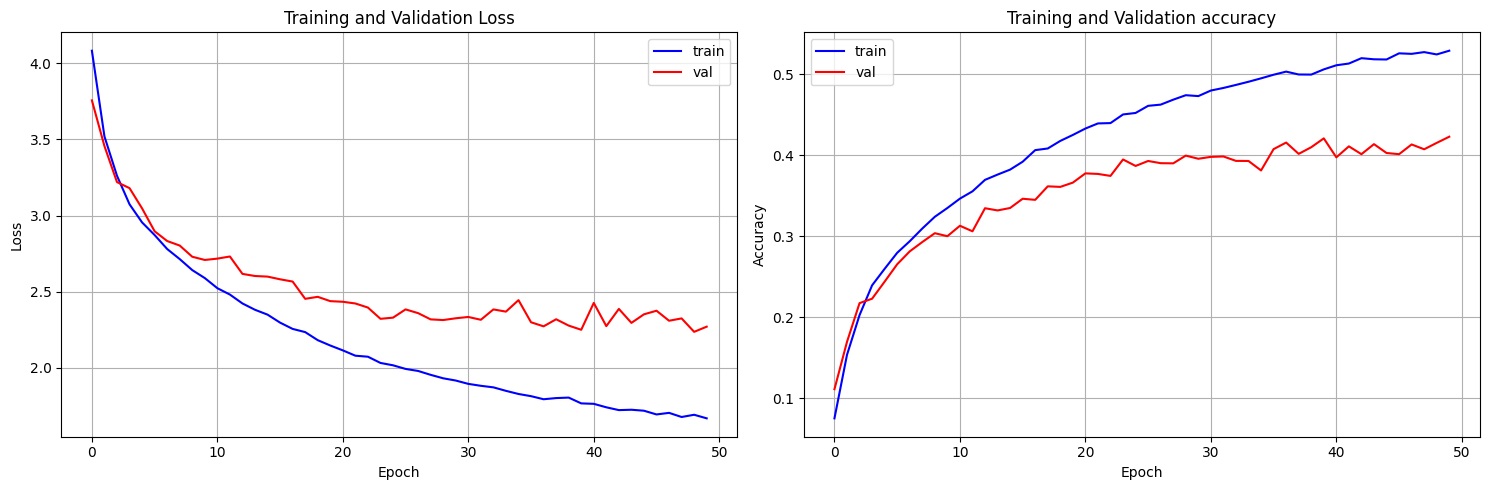

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(metrics['train_loss'], label='train', color='b', linestyle='-')
axes[0].plot(metrics['val_loss'], label='val', color='r', linestyle='-')
axes[0].set_title('Training and Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(metrics['train_accu'], label='train', color='b', linestyle='-')
axes[1].plot(metrics['val_accu'], label='val', color='r', linestyle='-')
axes[1].set_title('Training and Validation accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

# 收紧布局
plt.tight_layout()
# 显示图形
plt.show()

# Extract Attention

注意力分数矩阵的形状是什么样的呢？因为图像的分辨率是 `32x32` ，然后图块大小是 `4x4` ，所以一张图像总共是编码为 64 个图块 token。自注意力机制就是每个 token 对序列中其他 token 的相似度分数，所以矩阵代表了 64 个 token 对序列中 64 个 token 的笛卡尔乘积关系，因此是 $64\times 64$ 的形状。

一个多头自注意力机制包括了多个自注意力机制模块，这里设置的参数是 6 个头，因此一个 MultiHeadAttention 拥有的注意力矩阵就是 $6\times64\times64$ 。

ViT 论文中一个编码器 Encoder 使用一个多头子注意力机制，但是整体的编码流程是多个编码器 Encoder 的叠加，这里设置的编码器级联数量是 $6$ 个，所以总的 ViT 模型含有的注意力矩阵就是 $[B, 6, 6, 64, 64]$ ，这里可以把每个编码器包含的多头自注意力机制注意力矩阵叠加，变成 $[B, 36, 64, 64]$ 。但是，由于除了图像卷积编码出来的 64 个 token ，实际上后面还会在序列头部添加一个 `cls_token` ，因此实际的注意力分数矩阵是 $65\times65$ 。在进行注意力可视化的时候，是说只提取 `cls_token` 的对其他 token 的注意力相似度分数，因此索引选择是 `attention_maps[:, :, 0, 1:]` ，这里第三维的 $0$ 表示选取 `cls_token` 对其他 token 的注意力计算出来的分数行，然后这一行分数里面跳过第 0 个值，因为 `cls_token` 默认放在序列的首位，所以矩阵的对角线来说第一个元素是它自己对自己的注意力相似度计算，没有使用价值，因此跳过第一个值。

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT(**model_config).to(
    torch.device("cuda" if torch.cuda.is_available() else "cpu")
)
model.load_state_dict(torch.load("log/ViT/20250215204039/ckpt/best.pth"))
model.eval()

samples = [test_dataset[i] for i in \
           random.sample(range(len(test_dataset)), 4)]
data, gdth = zip(*samples)

with torch.no_grad():
    data = torch.stack(data).to(device)
    pred = model(data, retain_attn=True)
    pred = torch.argmax(pred, dim=1)
    # attention from each encoder block
    # [B, num_heads, patch^2 + 1, patch^2 + 1]
    # `+1` means the positional encoding
    attention_map = model.attention
    # gather all attention map in list
    attention_map = torch.cat(attention_map, dim=1)
    # select only the cls_token to others similarities attention
    attention_map = attention_map[:, :, 0, 1:]
    # average all attention maps
    attention_map = attention_map.mean(dim=1)
    # reshape to grid cell
    attention_map = attention_map.view(
        -1,
        model_config.image_shape[0] // model_config.patch_shape[0],
        model_config.image_shape[1] // model_config.patch_shape[1]
    )
    # resize attention map to input image size
    




torch.Size([4, 6, 65, 65])
torch.Size([4, 6, 65, 65])
torch.Size([4, 6, 65, 65])
torch.Size([4, 6, 65, 65])
torch.Size([4, 6, 65, 65])
torch.Size([4, 6, 65, 65])
torch.Size([4, 36, 65, 65])


In [15]:
4**0.5

2.0